## Data_Visualization_EIS.ipynb
#### Analyzes EIS Data from Big Kahuna for Convenient Feedback.
##### Miles Smith
##### 19 September 2023

In [122]:
import glob
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
# Note that altair was downgraded to v3.0 for impedance.
from impedance.visualization import plot_nyquist


### Read in all file names in EIS folder ###

# Specify the directory path and file extension pattern
directory_path = '/Users/milessmith/Desktop/EIS/' # Miles MacBook Pro (for testing)
# directory_path = 'C:\EIS' # Unchained Labs computer
extension_pattern = '*.txt'  # List .txt files, for example

# Get a list of file names matching the pattern in the directory
path_names = glob.glob(os.path.join(directory_path, extension_pattern))

### Select files of interest ###

'''
Example File structure: 103965_5_20230918_073125_25.txt
Plate Number: 103965
Vial Number (?): 5
Date: 20230918
Vial Code (?): 073125
Temperature (degC): 25
'''

### NOTICE: The underscores are an important aspect of the strings for temp and vial number. ###
# plate_number = '103965_'
plate_number = "skip"

vial_number = '_5_'
# vial_number = "skip"

date = '_20230918_'
# date = "skip"

temperature = '_25'
# temperature = "skip"

# New list to append the files of interest
useful_path = []


for path in path_names:
    if (date in path) or (date == "skip"):
        if (vial_number in path) or (vial_number == "skip"):
            if (temperature in path) or (temperature == "skip"):
                if (plate_number in path) or (plate_number == "skip"):
                    useful_path.append(path)
                else:
                    pass
            else:
                pass
        else:
            pass
    else:
        pass

print("Number of files selected: " + str(len(useful_path)))

Number of files selected: 1


In [123]:
'''
The text (.txt) does not include the frequency, so I am manually importing this from a .mpt file. 
If we adjust the frequency range, then we will need to adjust this, but from my observations we always sample
using the same frequencies. This could be subject to change if we ever changed the scan rate, so it is
important to be mindful!
'''

# Note: Freq[Hz]
frequency = [ 6999984, 5969734, 5091109, 4341796, 3702781, 3157797, 2693047, 2296687, 1958656,1670375,
             1424531,1214875,1036062,883578.100000000,753531.200000000,642624.900000000,548046.800000000, 
             467390.600000000, 398593.700000000, 339937.500000000, 289906.200000000, 247234.400000000, 
             210843.700000000, 179812.500000000, 153343.800000000, 130781.200000000, 111531.300000000,  
             95109.3700000000, 81109.3700000000, 69171.8800000000, 59000, 50312.5000000000, 42906.2500000000, 
             36593.7500000000, 31203.1300000000, 26609.3800000000, 22703.1300000000, 19359.3700000000,  
             16500, 14112.0200000000, 12011.1300000000, 10236.3800000000, 8750.68400000000, 7449.46300000000, 
             6363.20600000000, 5414.76100000000, 4620.56700000000, 3941.21500000000, 3361.76900000000, 
             2867.24400000000, 2442.65800000000, 2083.00300000000, 1777.84300000000, 1513.54800000000, 
             1292.06500000000, 1101.76200000000, 939.101000000000, 801.280100000000, 684.343300000000, 
             582.947600000000, 497.067700000000, 423.508900000000, 361.503600000000, 308.126200000000, 
             262.729800000000, 224.211100000000, 191.285400000000, 163.172200000000, 139.153700000000, 
             118.670600000000, 101.198200000000, 86.2419600000000, 73.6102400000000, 62.6929100000000, 
             53.5769700000000, 45.6574600000000, 38.9651200000000, 33.1841400000000, 28.3061700000000, 
             24.1723700000000, 20.6134500000000, 17.5561800000000, 14.9855800000000, 12.7655300000000, 
             10.8809000000000, 9.27850500000000, 7.92339400000000, 6.75822000000000, 5.76142900000000, 
             4.91970800000000, 4.19125700000000, 3.56409700000000, 3.05175800000000, 2.60416400000000, 
             2.21442400000000, 1.89256700000000, 1.60750700000000, 1.37641300000000, 1.17375000000000, 
             1.00160400000000 ]

for i in range(len(frequency)):
    frequency[i] = int(frequency[i])

f = np.array(frequency)
    

### Data Import, Basic Analysis, and Figures
Here I imported the data from the system and did basic calculations for further analysis.


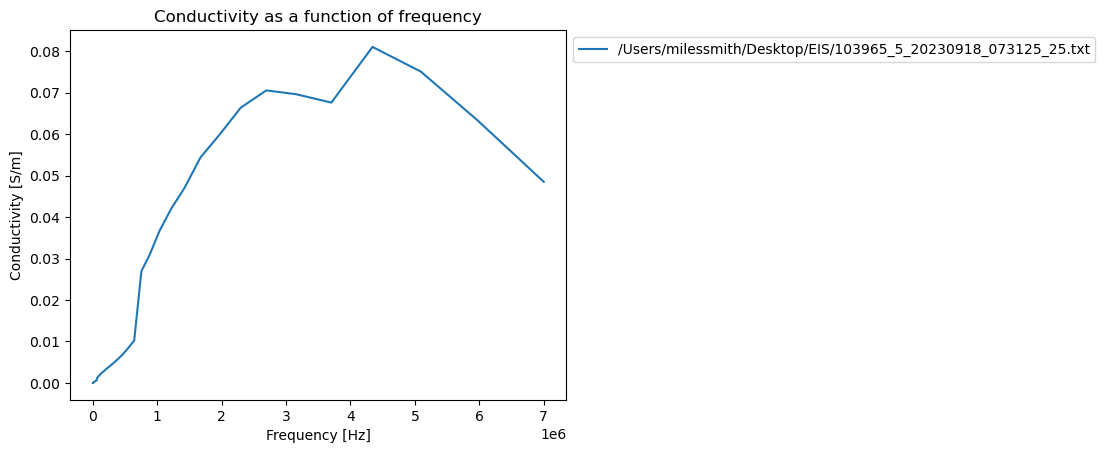

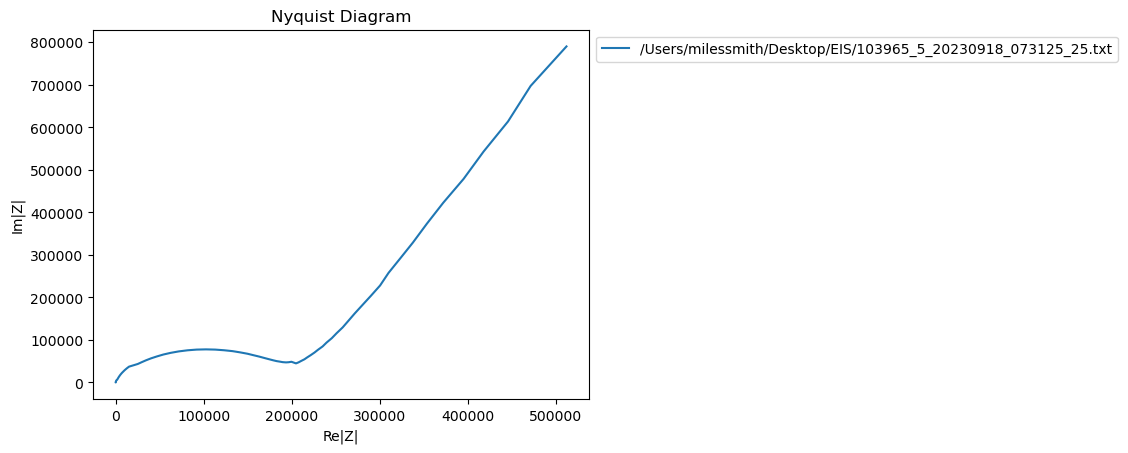

<Figure size 640x480 with 0 Axes>

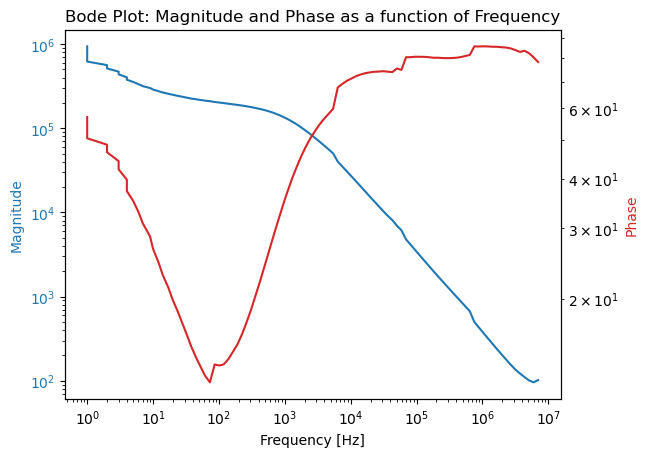

In [136]:
'''
Open and manage data from .txt files
'''
for path in useful_path: 
    
    # Open the file for reading
    with open(path, 'r') as file:
        
        # Initialize arrays for impedance and conductivity values.
        ReZOhm = []
        ImZOhm = []
        conductivity = []
        i = 0
        
        # Parse each line in the .txt files to the correct array.
        for line in file:
            ZOhm_Values = line.split()
            ReZOhm.append(float(ZOhm_Values[0]))
            ImZOhm.append(float(ZOhm_Values[1]))
            
            # resistivity = resistance (ReZ) * area / length
            # where area = cross-sectional area, length = distance between electrodes
            # These should eventually move to the header tab for user parameters
            diameter = 0.010 # [m] User-input required here
            length = 0.001 # [m] # User-input
            area = math.pi*diameter/4
            # Setting A and l to 1 makes this just conductance
            area = 1
            length = 1 
            resistivity = ReZOhm[i] * (area**2) / length
            conductivity.append(1/resistivity)
            i += 1
            
        ZOhm = []
        ZVector = []
        ZPhase = []
        for i in range(len(ReZOhm)):
            Z_temp = ReZOhm[i] - 1j*ImZOhm[i] # Rearrange into format of array. 
            ZOhm.append(Z_temp)
            ZVector.append(math.sqrt(ReZOhm[i]**2+ImZOhm[i]**2))
            ZPhase.append(math.atan(ImZOhm[i]/ReZOhm[i])*180/math.pi) # Phase in degrees = atan(Im|Z|/Re|Z|)
            
        '''
        Make figures 
        '''
        if len(frequency) == len(conductivity):
            plt.figure(1)
            plt.plot(frequency, conductivity, label = path)
            plt.title('Conductivity as a function of frequency')
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Conductivity [S/m]')
            plt.legend(bbox_to_anchor=(1, 1))
            # plt.ylim((0, 10))

            plt.figure(2)
            #plt.loglog(ReZOhm, ImZOhm, label = path) # I know this is unconventional, but it makes it easier to look at multiple lines.
            plt.plot(ReZOhm, ImZOhm, label = path) # I know this is unconventional, but it makes it easier to look at multiple lines.=
            plt.title('Nyquist Diagram')
            plt.xlabel('Re|Z|')
            plt.ylabel('Im|Z|')
            plt.legend(bbox_to_anchor=(1, 1))
            # plt.xlim((0, 250000))
            # plt.ylim((0, 100000))
            
            plt.figure(3)
            fig, ax1 = plt.subplots()
            plt.title('Bode Plot: Magnitude and Phase as a function of Frequency')
            color = 'tab:blue'
            ax1.set_xlabel('Frequency [Hz]')
            ax1.set_ylabel('Magnitude', color=color)
            ax1.loglog(frequency, ZVector, label = path)
            ax1.tick_params(axis='y', labelcolor=color)

            ax2 = ax1.twinx()
            color = 'tab:red'
            ax2.set_ylabel('Phase', color=color)  # we already handled the x-label with ax1
            ax2.loglog(frequency, ZPhase, color = color)
            ax2.tick_params(axis='y', labelcolor=color)
            

        else:
            print("Dimensionality Error in file:" + path + "\nLength of Conductivity Array:" + str(len(conductivity)))


    
    # Testing the magnitude and phase -- Looks good to me
    # print("Magnitude of Z: " + str(ZVector[1]))
    # print("Re|Z|: " + str(ReZOhm[1]) + "Im|Z|: " +str(ImZOhm[1]))
    # print("Phase of Z: " + str(ZPhase[1]))


### Implement Kronigs-Kramer Relations for Data Validation
First 


Circuit string: R0-p(R1,C1)-p(R2-Wo1,C2)
Fit: True

Initial guesses:
     R0 = 1.00e+04 [Ohm]
     R1 = 1.00e+00 [Ohm]
     C1 = 1.00e+05 [F]
     R2 = 1.00e+05 [Ohm]
  Wo1_0 = 1.00e+05 [Ohm]
  Wo1_1 = 1.00e-01 [sec]
     C2 = 1.00e-10 [F]

Fit parameters:
     R0 = 7.80e+03  (+/- 3.62e+03) [Ohm]
     R1 = 2.65e+05  (+/- 4.48e+00) [Ohm]
     C1 = 9.28e+04  (+/- 1.84e-07) [F]
     R2 = 1.28e+05  (+/- 7.90e+03) [Ohm]
  Wo1_0 = 7.95e+05  (+/- 2.06e+03) [Ohm]
  Wo1_1 = 2.11e-01  (+/- 4.19e-03) [sec]
     C2 = 5.01e-10  (+/- 1.04e-09) [F]



<Figure size 640x480 with 0 Axes>

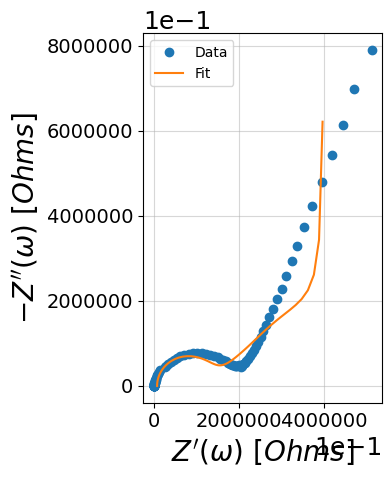

In [137]:
    # Create ECM and fit to the data collected
    circuit = 'R0-p(R1,C1)-p(R2-Wo1,C2)' # ECM. We should match model from system!
    initial_guess = [10**4, 10**0, 10**5, 10**5, 10**5, 10**-1, 10**-10]
    circuit = CustomCircuit(circuit, initial_guess=initial_guess)

        
    # Z = np.array(ZOhm)
    Z = ZOhm
    # f, Z = preprocessing.ignoreBelowX(f, Z)
    ### -- Still needs to be understood better! -- ###
    # Fit data to equivalent circuit model
    circuit.fit(f, Z)
    print(circuit)
    Z_fit = circuit.predict(f)
    plt.figure(3)
    fig, ax = plt.subplots()
    plot_nyquist(Z, fmt='o', scale=10, ax=ax)
    plot_nyquist(Z_fit, fmt='-', scale=10, ax=ax)

    plt.legend(['Data', 'Fit'])